# Daily Total Energy Forecasting (March - July) -> (August)

### Libraries & Setup

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 2000)

### Data Loading

In [193]:
df_march = pd.read_csv("../data/tpe6_march_2025_daily.csv")
df_april = pd.read_csv("../data/tpe6_april_2025_daily.csv")
df_may = pd.read_csv("../data/tpe6_may_2025_daily.csv")
df_june = pd.read_csv("../data/tpe6_june_2025_daily.csv")
df_july = pd.read_csv("../data/tpe6_july_2025_daily.csv")

# Combine all monthly data into a single DataFrame
df = pd.concat([df_march, df_april, df_may, df_june, df_july], ignore_index=True)

print(f"Combined Data Shape: {df.shape}\n")
print("Data Preview:", df.head())

Combined Data Shape: (153, 231)

Data Preview:                       DateTime   [EnerjiAnalizor_TPE_0006.Current]   [EnerjiAnalizor_TPE_0006.Total_Kwh]   [EnerjiAnalizor_TPE_0006.Total_Power]   [EnerjiAnalizor_TPE_0006.Voltage_LL]   [EnerjiAnalizor_TPE_0006.Voltage_LN]   [GalaLine_TPE_0006.Die_Plate_Temp]   [GalaLine_TPE_0006.DiePlate]   [GalaLine_TPE_0006.DiverterValve]   [GalaLine_TPE_0006.Knife_Press]   [GalaLine_TPE_0006.Knife_Rpm]   [GalaLine_TPE_0006.MeltDiff]   [GalaLine_TPE_0006.MeltInlet]   [GalaLine_TPE_0006.MeltOutlet]   [GalaLine_TPE_0006.MeltPump]   [GalaLine_TPE_0006.MeltTempAct]   [GalaLine_TPE_0006.PDV_Press]   [GalaLine_TPE_0006.PelletizerRPM]   [GalaLine_TPE_0006.PressureForce]   [GalaLine_TPE_0006.ScreenChangerDiff]   [GalaLine_TPE_0006.ScreenChangerIn]   [GalaLine_TPE_0006.ScreenChangerOut]   [GalaLine_TPE_0006.Water_Temp]   [GalaLine_TPE_0006.WaterLevel]   [GalaLine_TPE_0006.WaterPump]   [GalaLine_TPE_0006.WaterTemp]   [TPE_0006.Active_Oil_Tank]   [TPE_0006.Active_

### Data Preparation

In [194]:
# Convert DateTime column to datetime type and set as index
df["DateTime"] = pd.to_datetime(df["DateTime"])
df = df.set_index("DateTime")

# Drop columns with all missing values
missing_counts = df.isnull().sum()
cols_to_drop = missing_counts[missing_counts == 153].index
df = df.drop(columns=cols_to_drop)
print(f"{len(cols_to_drop)} columns dropped.\n")

# Drop columns with a single unique value
unique_counts = df.nunique()
cols_to_drop = unique_counts[unique_counts == 1].index
df = df.drop(columns=cols_to_drop)
print(f"{len(cols_to_drop)} columns dropped: {list(cols_to_drop)}\n")

# Remove square brackets from column names
df.columns = df.columns.str.strip().str.replace("[", "").str.replace("]", "")

# Remove TPE 0006
df.columns = df.columns.str.replace(r"_TPE_\d+\.", "_", regex=True)
df.columns = df.columns.str.replace(r"TPE_\d+\.", "", regex=True)

df = df[[
    "EnerjiAnalizor_Current",
    "EnerjiAnalizor_Total_Power",
    "EnerjiAnalizor_Voltage_LL",
    "EnerjiAnalizor_Voltage_LN",
    "EnerjiAnalizor_Total_Kwh",
    #"Running"
]]

# Feature engineering: Daily Consumption
df["Daily_Energy_Consumption"] = df["EnerjiAnalizor_Total_Kwh"].diff().clip(lower=0).fillna(0)

# Show null value counts
print("Null Value Counts:")
print(df.isnull().sum())

74 columns dropped.

32 columns dropped: [' [TPE_0006.BarrelZone01_Act]', ' [TPE_0006.BarrelZone01_Set]', ' [TPE_0006.BarrelZone15_Act]', ' [TPE_0006.BarrelZone15_Set]', ' [TPE_0006.CoolingWater]', ' [TPE_0006.DosingUnit09_Act]', ' [TPE_0006.DosingUnit09_ActPercent]', ' [TPE_0006.DosingUnit09_FeederSpeed]', ' [TPE_0006.DosingUnit09_Set]', ' [TPE_0006.DosingUnit09_SetPercent]', ' [TPE_0006.DosingUnit10_Act]', ' [TPE_0006.DosingUnit10_ActPercent]', ' [TPE_0006.DosingUnit10_FeederSpeed]', ' [TPE_0006.DosingUnit10_Set]', ' [TPE_0006.DosingUnit10_SetPercent]', ' [TPE_0006.DosingUnitTotalizer10]', ' [TPE_0006.DosingUnitTotalizer9]', ' [TPE_0006.Filter]', ' [TPE_0006.MeltTemp01_Act]', ' [TPE_0006.Oil1Percent]', ' [TPE_0006.Oil1Totalizer]', ' [TPE_0006.Oil2Percent]', ' [TPE_0006.Oil2Totalizer]', ' [TPE_0006.OilFirstEnj]', ' [TPE_0006.OilFourthEnj]', ' [TPE_0006.OilSecondEnj]', ' [TPE_0006.OilThirdEnj]', ' [TPE_0006.OpenedHole]', ' [TPE_0006.RPM]', ' [TPE_0006.ScrewProfileCode]', ' [TPE_0006.To

### Data Visualization

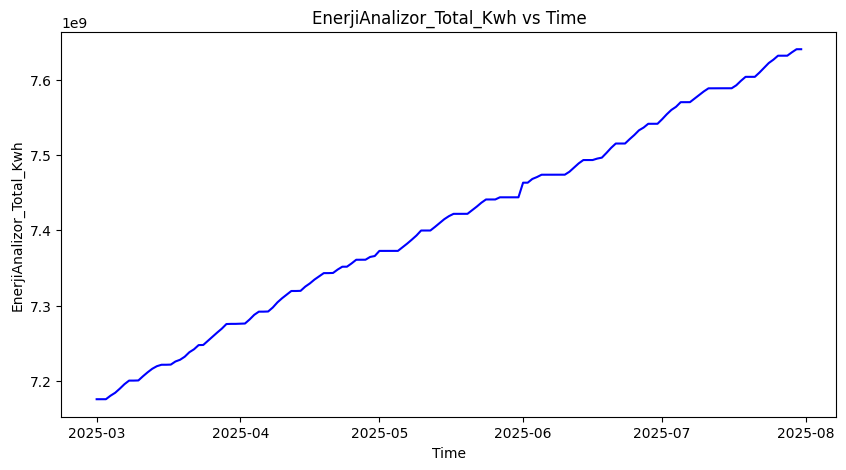

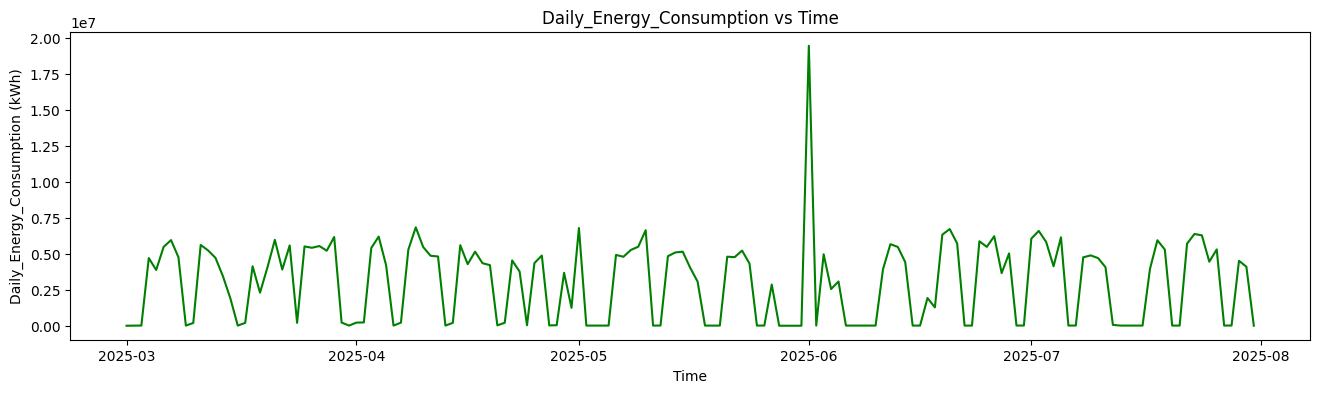

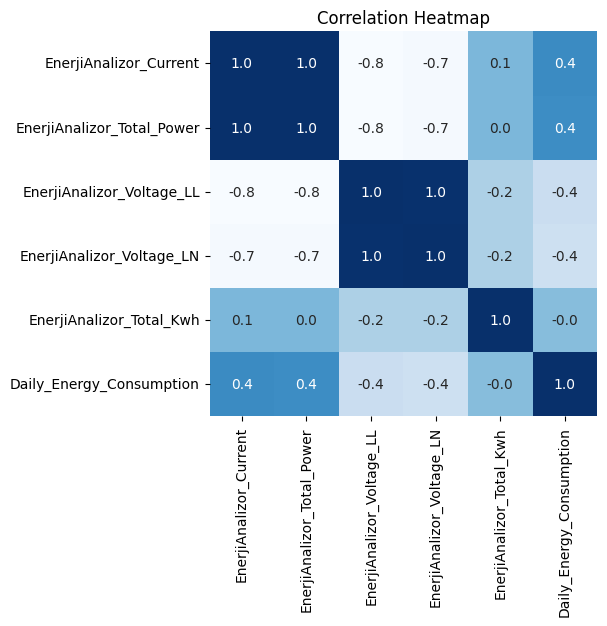

In [195]:
# Plot EnerjiAnalizor_Total_Kwh vs Time
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["EnerjiAnalizor_Total_Kwh"], color="blue")
plt.title("EnerjiAnalizor_Total_Kwh vs Time")
plt.xlabel("Time")
plt.ylabel("EnerjiAnalizor_Total_Kwh")
plt.show()

# Plot Daily_Energy_Consumption vs Time
plt.figure(figsize=(16, 4))
plt.plot(df.index, df["Daily_Energy_Consumption"], color="green")
plt.title("Daily_Energy_Consumption vs Time")
plt.xlabel("Time")
plt.ylabel("Daily_Energy_Consumption (kWh)")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(df.corr(), annot=True, cbar=False, cmap='Blues', fmt='.1f')
plt.title("Correlation Heatmap")
plt.show()

### Feature Engineering

            EnerjiAnalizor_Current  EnerjiAnalizor_Total_Power  EnerjiAnalizor_Total_Kwh  Daily_Energy_Consumption         lag_1  lag_7  lag_14  lag_28  dayofweek  month  is_weekend
DateTime                                                                                                                                                                             
2025-03-01                1.014625                  328.217468              7.175450e+09              0.000000e+00  0.000000e+00    0.0     0.0     0.0          5      3           1
2025-03-02                1.058811                  337.972778              7.175458e+09              8.331493e+03  0.000000e+00    0.0     0.0     0.0          6      3           1
2025-03-03              196.740219               135080.046875              7.175471e+09              1.235893e+04  8.331493e+03    0.0     0.0     0.0          0      3           0
2025-03-04              345.246735               219013.500000              7.180168e+09  

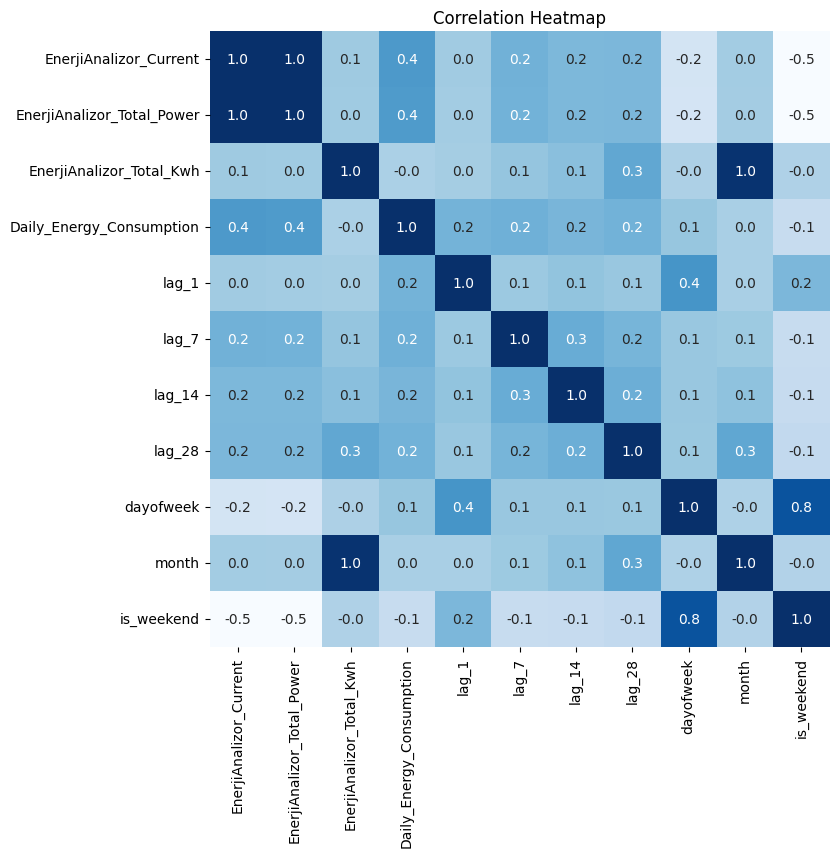

In [196]:
# No correlation with Voltage columns then drop them
df = df.drop(columns=["EnerjiAnalizor_Voltage_LL", "EnerjiAnalizor_Voltage_LN"])

# Create lag & time features
def create_features(df):
    df_feat = df.copy()
    # Lags (daily consumption)
    for lag in [1,7,14,28]:
        df_feat[f"lag_{lag}"] = df_feat["Daily_Energy_Consumption"].shift(lag)

    # Time features
    df_feat["dayofweek"] = df_feat.index.dayofweek
    df_feat["month"] = df_feat.index.month
    df_feat["is_weekend"] = (df_feat.index.dayofweek >= 5).astype(int)
        
    # Fill NA (initial rows)
    df_feat = df_feat.fillna(method="bfill").fillna(0)
    return df_feat

df_feat = create_features(df)
print(df_feat.head())

# Feature columns to use for tree models
feature_cols = ["EnerjiAnalizor_Current", "EnerjiAnalizor_Total_Power", #"Running",
                "lag_1", "lag_7", "lag_14", "lag_28", "dayofweek", "month",
                "is_weekend"]

# Correlation Heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(df_feat.corr(), annot=True, cbar=False, cmap='Blues', fmt='.1f')
plt.title("Correlation Heatmap")
plt.show()

### Train / Validation split

In [197]:
train_end = pd.to_datetime("2025-06-30")   # train: March->June
val_start = pd.to_datetime("2025-07-01")   # validation: July
val_end = pd.to_datetime("2025-07-31")

train_mask = (df_feat.index <= train_end)
val_mask = (df_feat.index >= val_start) & (df_feat.index <= val_end)

X_train = df_feat.loc[train_mask, feature_cols]
y_train = df_feat.loc[train_mask, "Daily_Energy_Consumption"]

X_val = df_feat.loc[val_mask, feature_cols]
y_val = df_feat.loc[val_mask, "Daily_Energy_Consumption"]

print("Train size:", X_train.shape, " Val size:", X_val.shape)

Train size: (122, 9)  Val size: (31, 9)


### Tree Models Training & Evaluation

In [198]:
# Train RandomForest & XGBoost
rf = RandomForestRegressor(n_estimators=400, max_depth=10, min_samples_split=5, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

xgb = XGBRegressor(n_estimators=500, learning_rate=0.2, random_state=42)
xgb.fit(X_train, y_train)

# Evaluate on validation set (tree models)
def evaluate_preds(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {"MAE":mae, "RMSE":rmse}

pred_rf_val = rf.predict(X_val)
print("RandomForest validation metrics:", evaluate_preds(y_val, pred_rf_val))

pred_xgb_val = xgb.predict(X_val)
print("XGBoost validation metrics:", evaluate_preds(y_val, pred_xgb_val))

RandomForest validation metrics: {'MAE': 1144169.9751358107, 'RMSE': np.float64(1565523.4029584816)}
XGBoost validation metrics: {'MAE': 1078097.7157965938, 'RMSE': np.float64(1704635.6933654218)}


### LSTM Model Training & Evaluation

In [199]:
# Generating sequence data only from Daily_Energy_Consumption
series = df["Daily_Energy_Consumption"].values.reshape(-1,1)
scaler = StandardScaler()
series_scaled = scaler.fit_transform(series)

seq_len = 14
X_seq, y_seq = [], []
for i in range(seq_len, len(series_scaled)):
    X_seq.append(series_scaled[i-seq_len:i])
    y_seq.append(series_scaled[i])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Train/Val split index
split_idx = df.index.get_loc(val_start)
X_train_seq, y_train_seq = X_seq[:split_idx], y_seq[:split_idx]
X_val_seq, y_val_seq = X_seq[split_idx:], y_seq[split_idx:]

# LSTM model
model = Sequential()
model.add(LSTM(64, activation="relu", input_shape=(seq_len,1)))
model.add(Dense(32, activation="relu"))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.0001), loss="mse")
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=100, batch_size=8, verbose=1, callbacks=[early_stop])

y_val_pred_scaled = model.predict(X_val_seq)
y_val_pred = scaler.inverse_transform(y_val_pred_scaled)
y_val_true = scaler.inverse_transform(y_val_seq)

print("LSTM MAE, RMSE:", evaluate_preds(y_val_true, y_val_pred))

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.0554 - val_loss: 0.8591
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0545 - val_loss: 0.8588
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0538 - val_loss: 0.8585
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0532 - val_loss: 0.8581
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0529 - val_loss: 0.8576
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0522 - val_loss: 0.8572
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0517 - val_loss: 0.8567
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0512 - val_loss: 0.8562
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0511 - val_loss: 0.8558
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0505 - val_loss: 0.8555
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0500 - val_loss: 0.8550
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.

### Feature Forecast Stage

In [200]:
feature_targets = ["EnerjiAnalizor_Current", "EnerjiAnalizor_Total_Power"]#, "Running"]
last_date = df.index.max()
last_total = df["EnerjiAnalizor_Total_Kwh"].iloc[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=31)

feature_models = {}
future_feature_preds = pd.DataFrame(index=future_dates)

for ft in feature_targets:
    print(f"Training feature model for: {ft}")
    X_train_ft = df_feat.loc[train_mask, ["lag_1","lag_7","lag_14","lag_28","dayofweek","month","is_weekend"]]
    y_train_ft = df_feat.loc[train_mask, ft]

    model_ft = XGBRegressor(n_estimators=500, learning_rate=0.2, random_state=42)
    model_ft.fit(X_train_ft, y_train_ft)
    feature_models[ft] = model_ft

    # Forecast step-by-step
    history_ft = df_feat.copy()
    preds_ft = []
    for date in future_dates:
        feat_ft = {
            "lag_1": history_ft[ft].iloc[-1],
            "lag_7": history_ft[ft].iloc[-7],
            "lag_14": history_ft[ft].iloc[-14],
            "lag_28": history_ft[ft].iloc[-28],
            "dayofweek": date.dayofweek,
            "month": date.month,
            "is_weekend": 1 if date.dayofweek >= 5 else 0
        }
        X_new_ft = pd.DataFrame([feat_ft])
        pred_ft = model_ft.predict(X_new_ft)[0]
        preds_ft.append(pred_ft)
        history_ft.loc[date, ft] = pred_ft

    future_feature_preds[ft] = preds_ft

print("\nFuture feature forecasts ready:")
print(future_feature_preds.head())

Training feature model for: EnerjiAnalizor_Current
Training feature model for: EnerjiAnalizor_Total_Power

Future feature forecasts ready:
            EnerjiAnalizor_Current  EnerjiAnalizor_Total_Power
2025-08-01              331.222931               147091.500000
2025-08-02                1.155759                 1645.076782
2025-08-03                1.194154                  371.872589
2025-08-04              169.290848                11209.376953
2025-08-05              309.631866               126727.898438


### August Forecast (31 days) with Random Forest

In [201]:
rf_energy = RandomForestRegressor(n_estimators=400, max_depth=10, min_samples_split=5, random_state=42, n_jobs=-1)
rf_energy.fit(X_train, y_train)

rf_preds = []
total_rf = []
cur_total_rf = last_total

history_rf = df_feat.copy()

for i, date in enumerate(future_dates):
    # first, add feature forecast values
    history_rf.loc[date, "EnerjiAnalizor_Current"] = future_feature_preds.loc[date, "EnerjiAnalizor_Current"]
    history_rf.loc[date, "EnerjiAnalizor_Total_Power"] = future_feature_preds.loc[date, "EnerjiAnalizor_Total_Power"]
    #history_rf.loc[date, "Running"] = future_feature_preds.loc[date, "Running"]

    feat = {
        "EnerjiAnalizor_Current": history_rf.loc[date, "EnerjiAnalizor_Current"],
        "EnerjiAnalizor_Total_Power": history_rf.loc[date, "EnerjiAnalizor_Total_Power"],
        #"Running": history_rf.loc[date, "Running"],
        "lag_1": history_rf["Daily_Energy_Consumption"].iloc[-1],
        "lag_7": history_rf["Daily_Energy_Consumption"].iloc[-7],
        "lag_14": history_rf["Daily_Energy_Consumption"].iloc[-14],
        "lag_28": history_rf["Daily_Energy_Consumption"].iloc[-28],
        "dayofweek": date.dayofweek,
        "month": date.month,
        "is_weekend": 1 if date.dayofweek >= 5 else 0,
    }

    X_new = pd.DataFrame([feat])
    pred = rf_energy.predict(X_new)[0]
    rf_preds.append(pred)
    cur_total_rf += pred
    total_rf.append(cur_total_rf)

    history_rf.loc[date, "Daily_Energy_Consumption"] = pred

forecast_df = pd.DataFrame({
    "Daily_RF": rf_preds,
    "Total_RF": total_rf
}, index=future_dates)

### August forecast (31 days) with XGBoost

In [202]:
xgb_energy = XGBRegressor(n_estimators=500, learning_rate=0.2, random_state=42)
xgb_energy.fit(X_train, y_train)

xgb_preds = []
total_xgb = []
cur_total_xgb = last_total

history_xgb = df_feat.copy()

for i, date in enumerate(future_dates):
    # Add feature forecasts
    history_xgb.loc[date, "EnerjiAnalizor_Current"] = future_feature_preds.loc[date, "EnerjiAnalizor_Current"]
    history_xgb.loc[date, "EnerjiAnalizor_Total_Power"] = future_feature_preds.loc[date, "EnerjiAnalizor_Total_Power"]
    #history_xgb.loc[date, "Running"] = future_feature_preds.loc[date, "Running"]

    feat = {
        "EnerjiAnalizor_Current": history_xgb.loc[date, "EnerjiAnalizor_Current"],
        "EnerjiAnalizor_Total_Power": history_xgb.loc[date, "EnerjiAnalizor_Total_Power"],
        #"Running": history_xgb.loc[date, "Running"],
        "lag_1": history_xgb["Daily_Energy_Consumption"].iloc[-1],
        "lag_7": history_xgb["Daily_Energy_Consumption"].iloc[-7],
        "lag_14": history_xgb["Daily_Energy_Consumption"].iloc[-14],
        "lag_28": history_xgb["Daily_Energy_Consumption"].iloc[-28],
        "dayofweek": date.dayofweek,
        "month": date.month,
        "is_weekend": 1 if date.dayofweek >= 5 else 0,
    }

    X_new = pd.DataFrame([feat])
    pred = xgb_energy.predict(X_new)[0]
    xgb_preds.append(pred)
    cur_total_xgb += pred
    total_xgb.append(cur_total_xgb)

    history_xgb.loc[date, "Daily_Energy_Consumption"] = pred

forecast_df["Daily_XGB"] = xgb_preds
forecast_df["Total_XGB"] = total_xgb

### August Forecast (31 days) with LSTM

In [203]:
lstm_preds = []
total_lstm = []
cur_total_lstm = last_total

# Starting sequence (last 14 days)
last_seq = series_scaled[-seq_len:].copy()

for date in future_dates:
    X_input = last_seq.reshape(1, seq_len, 1)
    pred_scaled = model.predict(X_input, verbose=0)
    pred = scaler.inverse_transform(pred_scaled)[0][0]

    lstm_preds.append(pred)
    cur_total_lstm += pred
    total_lstm.append(cur_total_lstm)

    # Add new value to the sequence, remove the oldest
    new_val = pred_scaled[0][0]
    last_seq = np.vstack([last_seq[1:], [[new_val]]])

forecast_df["Daily_LSTM"] = lstm_preds
forecast_df["Total_LSTM"] = total_lstm

### Visualization - Compare Models

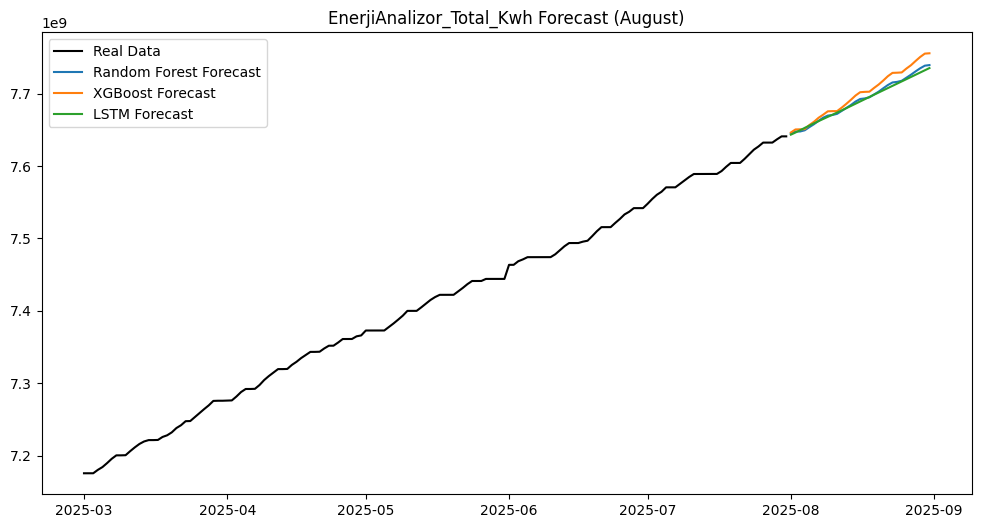

In [204]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df["EnerjiAnalizor_Total_Kwh"], label="Real Data", color="black")
plt.plot(forecast_df.index, forecast_df["Total_RF"], label="Random Forest Forecast")
plt.plot(forecast_df.index, forecast_df["Total_XGB"], label="XGBoost Forecast")
plt.plot(forecast_df.index, forecast_df["Total_LSTM"], label="LSTM Forecast")
plt.title("EnerjiAnalizor_Total_Kwh Forecast (August)")
plt.legend()
plt.show()

### Save Models

In [205]:
#joblib.dump(rf_energy, "../models/model_randomforest.pkl")
#joblib.dump(xgb_energy, "../models/model_xgb.pkl")
#joblib.dump(model, "../models/model_lstm.keras")